In [1]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [2]:
def get_data(
    assessment='Parent_Measures', 
    domain='Demographic_Questionnaire_Measures', 
    measure='Child_Behavior_Checklist.csv',
    abbrev='CBCL'):
    """get data from a particular questionnaire and accompanying questions from dictionary
    """
    
    # base directory
    base_dir = '/Users/maedbhking/Documents/healthy_brain_network/data/raw/phenotype/'

    # answers
    fpath = os.path.join(os.path.join(base_dir, assessment, domain, measure + '.csv'))
    df = pd.read_csv(fpath)
    df_A = df.filter(like=f'{abbrev},')

    # questions
    df_Q = pd.read_excel(os.path.join(base_dir, 'Release9_DataDic',  f'{abbrev}.xlsx'), header=1)

    # do some preprocessing on `Question`
    df_Q = df_Q[df_Q['Question'].str.contains('^[0-9]*[.] ')]
    df_Q['Question'] = df_Q['Question'].str.replace('/', ' or ').str.replace('^[0-9]*[.] ', '')
    df_Q = df_Q.dropna()
    
    # do some preprocessing on `Answer`
    df_A.columns = df_A.columns.str.replace(f'{abbrev},', '')
    columns = df_Q['Variable'].tolist()
    df_A = df_A[columns]
    
    return df_Q, df_A


def sentence_similarity(sentences):
    """calculate sentence similarity across all sentence combinations
    
    Args:
        sentences (list): list of sentences
    """
    from sentence_transformers import SentenceTransformer, util
    
    # get model
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')

    # calculate sentence embeddings
    sentence_embeddings = model.encode(sentences)
    
    #Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = util.cos_sim(sentence_embeddings, sentence_embeddings)
    
    #Find the pairs with the highest cosine similarity scores
    pairs = []
    for i in range(len(cosine_scores)-1):
        for j in range(i+1, len(cosine_scores)):
            pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

    #Sort scores in decreasing order
    pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
    
    return cosine_scores, pairs

def answer_similarity(dataframe, pairs):
    """calculate correlations across answers for all `pairs` of sentences
    
    Args:
        dataframe (pd dataframe):
        pairs (list of dict): output from `sentence_similarity`
    """
    
    # calculate correlations across answers
    df_corr = dataframe.corr()
    
    pairs_A = []
    for idx in range(len(pairs)):
        r = pairs[idx]['index'][0]
        c = pairs[idx]['index'][1]
        rcorr = df_corr.iloc[r,c]
        pairs_A.append(rcorr)
    
    return pairs_A

def plot_heatmap(array, labels=None):
    """plot heatmap of array with labels (optional)
    
    Args:
        array (np array):
        labels (list of str or None): optional
    """
    ax = sns.heatmap(array)
    
    if labels is not None:
        ax.set_xticklabels(
            labels,
            rotation=45,
            horizontalalignment='right'
            )
        ax.set_yticklabels(
            labels,
            rotation=360,
            horizontalalignment='right'
        )

    plt.show()
    
def plot_top_sentences(pairs, sentences, A_similarity=None, percent=10, title=None):
    """plot most similar sentences in a tabular format
    
    Args:
        pairs (list of dict): output from `sentence similarity`
        sentences (list of str): list of sentences
        A_similarity (list of str or None): (optional) output from `answer_similarity`
        percent (int): percentage of top sentences to print
    """
    from tabulate import tabulate
    
    pairs_all = pairs
    header = ["Sentence 1", "Sentence 2", "Question"]
    
    if A_similarity is not None:
        # add answer similarity score to `pairs` dictionary
        pairs_all = []
        header = ["Sentence 1", "Sentence 2", "Question", "Answer"]
        for r, score in zip(pairs, A_similarity):
            r.update({'score_A': score})
            pairs_all.append(r)

    #Output the pairs with their score
    top_sentences = []
    num_sentences = int(len(sentences)*percent/100)
    for pair in pairs_all[0:num_sentences]:
        i, j = pair['index']
        if A_similarity is not None:
            row = [sentences[i], sentences[j], round(pair['score'].tolist(),2), round(pair['score_A'],2)]
        else:
            row = [sentences[i], sentences[j], round(pair['score'].tolist(),2)]
        top_sentences.append(row)
         
    top_sentences.insert(0, header)
    head='firstrow'
    if title is not None:
        head = [title, '','','']
    print(tabulate(top_sentences, headers=head, tablefmt="grid"))



## Example - CBCL

/Users/maedbhking/.local/share/virtualenvs/cerebellum_learning_connect-99heifxR/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

The default value of regex will change from True to False in a future version.



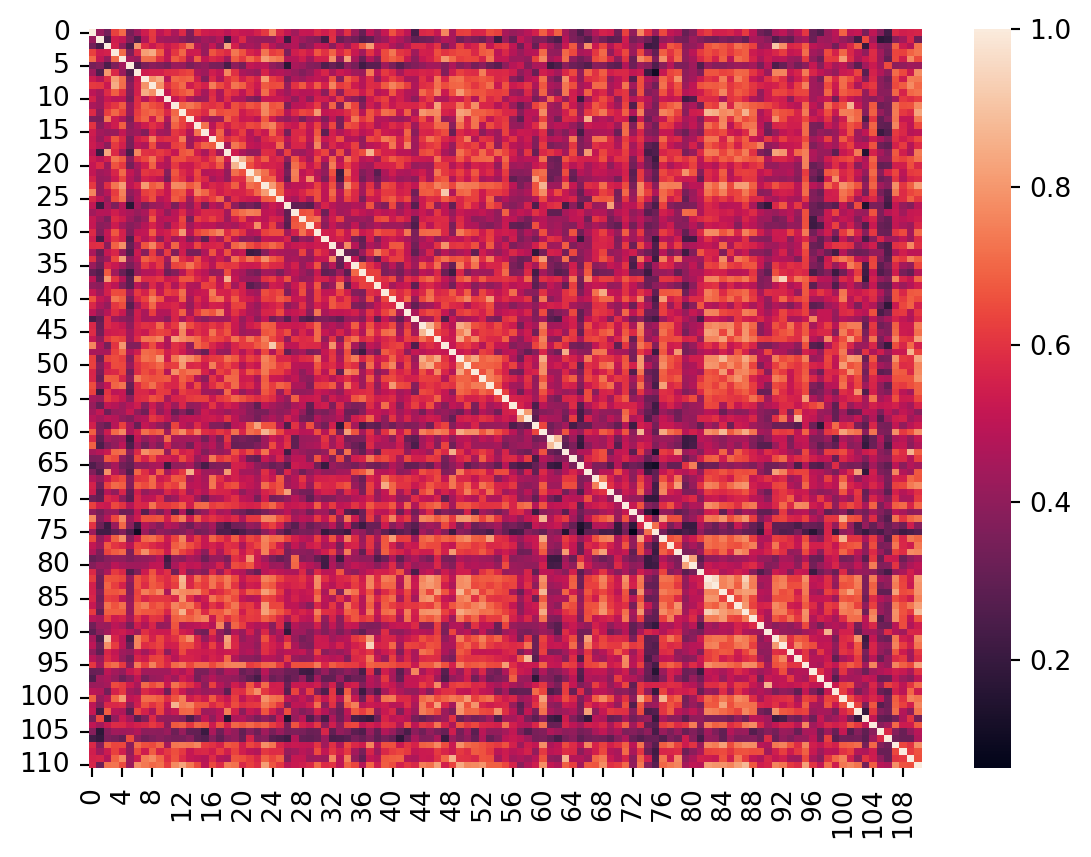

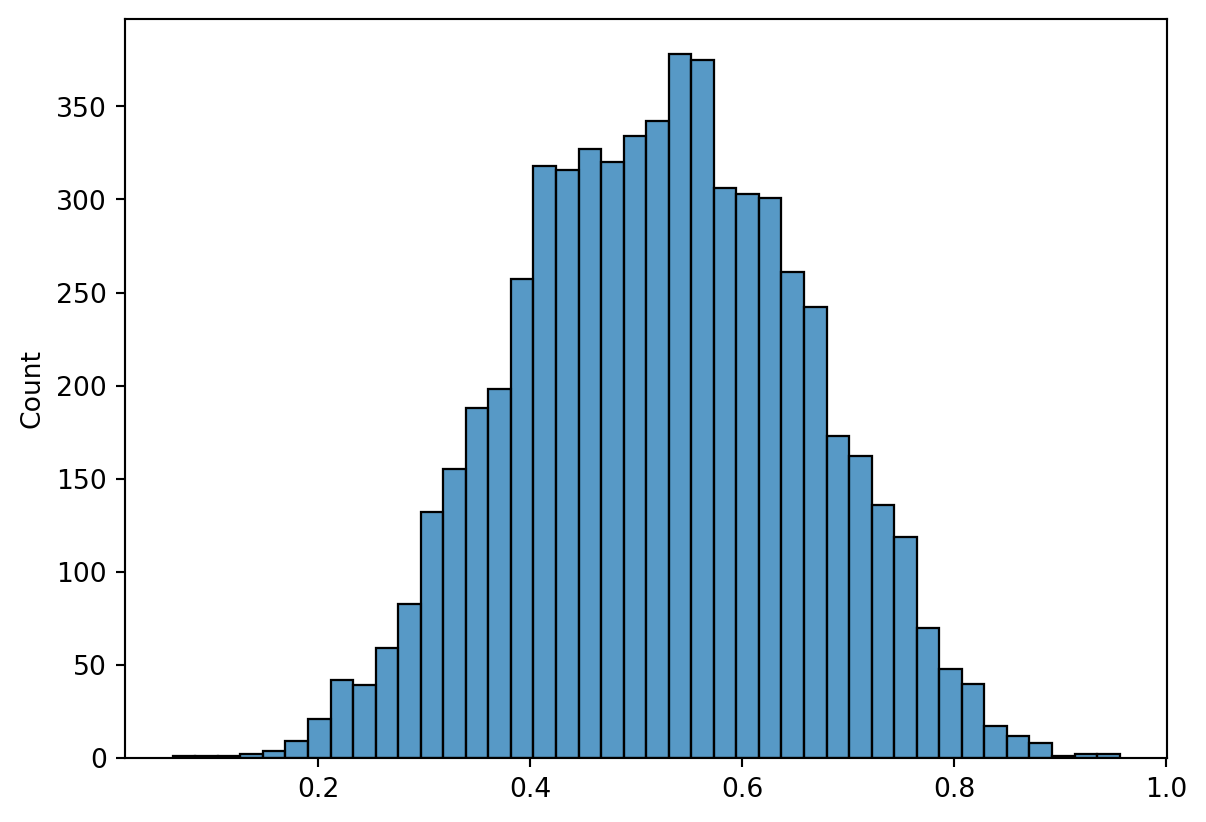

+----------------------------------------+---------------------------------+----------+--------+
| CBCL                                   |                                 |          |        |
+========================================+=================================+==========+========+
| Sentence 1                             | Sentence 2                      | Question | Answer |
+----------------------------------------+---------------------------------+----------+--------+
| Strange behavior                       | Strange ideas                   | 0.96     | 0.38   |
+----------------------------------------+---------------------------------+----------+--------+
| Gets teased a lot                      | Teases a lot                    | 0.94     | 0.26   |
+----------------------------------------+---------------------------------+----------+--------+
| Strange behavior                       | Suspicious                      | 0.93     | 0.25   |
+-----------------------------

In [3]:
# get data
df_Q, df_A = get_data(assessment='Parent_Measures', 
                    domain='Demographic_Questionnaire_Measures', 
                    measure='Child_Behavior_Checklist', # Child_Behavior_Checklist
                    abbrev='CBCL'
                    )

# sentences
sentences = df_Q['Question'].tolist()

# calculate sentence similarity
cosine_scores, pairs = sentence_similarity(sentences)

# plot heatmap
plot_heatmap(array=cosine_scores, labels=None)

# plot distribution of scores
scores = [r['score'].tolist() for r in pairs]
sns.histplot(scores)
plt.show()

# get answer similarity
A_similarity = answer_similarity(dataframe=df_A, pairs=pairs)

# plot table
plot_top_sentences(pairs, sentences, A_similarity, percent=10, title='CBCL')
